In [1]:
import os

max_files = 50  # number of files to print
count = 0

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        count += 1
        if count >= max_files:
            break
    if count >= max_files:
        break

/kaggle/input/nih-chest-x-rays-preprocessed-version/README_CHESTXRAY.pdf
/kaggle/input/nih-chest-x-rays-preprocessed-version/BBox_List_2017.csv
/kaggle/input/nih-chest-x-rays-preprocessed-version/test_list.txt
/kaggle/input/nih-chest-x-rays-preprocessed-version/Data_Entry_2017.csv
/kaggle/input/nih-chest-x-rays-preprocessed-version/train_val_list.txt
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00006199_010.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00004833_016.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00006260_000.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00004911_010.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00004186_007.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00004459_000.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00005004_001.png
/kaggle/input/nih-chest-x-rays-preproc

In [2]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from tqdm.auto import tqdm
import wandb
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve, confusion_matrix, multilabel_confusion_matrix
import numpy as np
from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# ---------------- CONFIG ---------------- #
CONFIG = {
    "model": "replication_of_dannynet",
    "batch_size": 6,
    "learning_rate": 0.00005,
    "epochs": 25,
    "num_workers": 2,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "data_dir": "/kaggle/input/nih-chest-x-rays-preprocessed-version",  # <- CHANGE to your Kaggle dataset path
    "patience": 5,
    "seed": 32,
    "image_size": 260,
}

In [5]:
print(CONFIG["device"])

cuda


In [6]:
# ---------------- TRANSFORMS ---------------- #
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(CONFIG["image_size"]),  # Use config
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

transform_test = transforms.Compose([
    transforms.Resize(CONFIG["image_size"] + 28),  # Add margin
    transforms.CenterCrop(CONFIG["image_size"]),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [7]:
# ---------------- MODEL ---------------- #
model = efficientnet_b2(weights=EfficientNet_B2_Weights.IMAGENET1K_V1)
# EfficientNet classifier is a Sequential module: [Dropout, Linear]
# We need to access the Linear layer (index 1) to get in_features
num_features = model.classifier[1].in_features
model.classifier = nn.Linear(num_features, 14)
model = model.to(CONFIG["device"])

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 156MB/s]


In [8]:
# ---------------- LOSS ---------------- #
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.bce = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [9]:
criterion = FocalLoss(alpha=1, gamma=2)
optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG["learning_rate"], weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.1)

In [10]:
# ---------------- DATA ---------------- #
data_path = CONFIG["data_dir"]
csv_file = os.path.join(data_path, "Data_Entry_2017.csv")
df = pd.read_csv(csv_file)

In [11]:
image_folders = [os.path.join(data_path, f"images_{str(i).zfill(3)}", "images") for i in range(1, 13)]
image_to_folder = {}
for folder in image_folders:
    if os.path.exists(folder):
        for img_file in os.listdir(folder):
            if img_file.endswith('.png'):
                image_to_folder[img_file] = folder


In [12]:
df = df[df['Image Index'].isin(image_to_folder.keys())]

In [13]:
unique_patients = df['Patient ID'].unique()
train_val_patients, test_patients = train_test_split(unique_patients, test_size=0.02, random_state= 42)
train_patients, val_patients = train_test_split(train_val_patients, test_size=0.052, random_state=CONFIG["seed"])

In [14]:
train_df = df[df['Patient ID'].isin(train_patients)]
val_df   = df[df['Patient ID'].isin(val_patients)]
test_df  = df[df['Patient ID'].isin(test_patients)]

In [15]:
disease_list = [
    'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
    'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass',
    'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'
]

In [16]:
def get_label_vector(labels_str):
    labels = labels_str.split('|')
    if labels == ['No Finding']:
        return [0] * len(disease_list)
    else:
        return [1 if disease in labels else 0 for disease in disease_list]

In [17]:
class CheXNetDataset(Dataset):
    def __init__(self, dataframe, image_to_folder, transform=None):
        self.dataframe = dataframe
        self.image_to_folder = image_to_folder
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx]['Image Index']
        folder = self.image_to_folder[img_name]
        img_path = os.path.join(folder, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        labels_str = self.dataframe.iloc[idx]['Finding Labels']
        labels = torch.tensor(get_label_vector(labels_str), dtype=torch.float)
        return image, labels

In [18]:
trainloader = DataLoader(CheXNetDataset(train_df, image_to_folder, transform=transform_train),
                         batch_size=CONFIG["batch_size"], shuffle=True, num_workers=CONFIG["num_workers"])
valloader = DataLoader(CheXNetDataset(val_df, image_to_folder, transform=transform_test),
                       batch_size=CONFIG["batch_size"], shuffle=False, num_workers=CONFIG["num_workers"])
testloader = DataLoader(CheXNetDataset(test_df, image_to_folder, transform=transform_test),
                        batch_size=CONFIG["batch_size"], shuffle=False, num_workers=CONFIG["num_workers"])

In [19]:
# ---------------- METRICS ---------------- #
def get_optimal_thresholds(labels, preds):
    thresholds = []
    for i in range(preds.shape[1]):
        precision, recall, thresh = precision_recall_curve(labels[:, i], preds[:, i])
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
        best_threshold = thresh[np.argmax(f1_scores)] if len(thresh) > 0 else 0.5
        thresholds.append(best_threshold)
    return thresholds

In [20]:
def evaluate(model, loader, criterion, device, desc="[Test]"):
    model.eval()
    running_loss = 0.0
    all_labels, all_preds = [], []
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc=desc):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            preds = torch.sigmoid(outputs)
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())

    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()
    thresholds = get_optimal_thresholds(all_labels, all_preds)

    preds_binary = np.zeros_like(all_preds)
    for i in range(all_preds.shape[1]):
        preds_binary[:, i] = (all_preds[:, i] > thresholds[i]).astype(int)

    auc_scores = [roc_auc_score(all_labels[:, i], all_preds[:, i]) for i in range(14)]
    f1_scores = [f1_score(all_labels[:, i], preds_binary[:, i]) for i in range(14)]

    avg_auc = np.mean(auc_scores)
    avg_f1 = np.mean(f1_scores)

    for i, disease in enumerate(disease_list):
        print(f"{desc} {disease} AUC: {auc_scores[i]:.4f} | F1: {f1_scores[i]:.4f}")

    print(f"{desc} Avg AUC: {avg_auc:.4f}, Avg F1: {avg_f1:.4f}")

    return {
        "loss": running_loss / len(loader),
        "avg_auc": avg_auc,
        "avg_f1": avg_f1,
        "auc_dict": dict(zip(disease_list, auc_scores)),
        "f1_dict": dict(zip(disease_list, f1_scores)),
        "thresholds": dict(zip(disease_list, thresholds))
    }


In [21]:
# ---------------- TRAINING ---------------- #
def train(epoch, model, trainloader, optimizer, criterion, CONFIG):
    device = CONFIG["device"]
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{CONFIG['epochs']} [Train]", leave=True)
    for i, (inputs, labels) in enumerate(progress_bar):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        progress_bar.set_postfix({"loss": running_loss / (i + 1)})
    train_loss = running_loss / len(trainloader)
    return train_loss


In [22]:
def validate(model, valloader, criterion, device):
    return evaluate(model, valloader, criterion, device, desc="[Validate]")


In [23]:
# ---------------- MAIN LOOP ---------------- #
checkpoint_dir = "models"
os.makedirs(checkpoint_dir, exist_ok=True)

best_val_auc = 0.0
patience_counter = 0

# Lists to store losses for plotting
train_losses = []
val_losses = []
epochs_list = []

print("Starting training...")
print("-" * 80)

for epoch in range(CONFIG["epochs"]):
    print(f"\nEpoch {epoch+1}/{CONFIG['epochs']}")
    print("-" * 40)
    
    # Training
    train_loss = train(epoch, model, trainloader, optimizer, criterion, CONFIG)
    
    # Validation
    val_stats = validate(model, valloader, criterion, CONFIG["device"])
    
    # Store losses for plotting
    train_losses.append(train_loss)
    val_losses.append(val_stats["loss"])
    epochs_list.append(epoch + 1)
    
    # Display epoch summary
    print(f"Training Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_stats['loss']:.4f}")
    print(f"Validation AUC: {val_stats['avg_auc']:.4f}")
    print(f"Validation F1: {val_stats['avg_f1']:.4f}")
    
    scheduler.step(val_stats["loss"])

    if val_stats["avg_auc"] > best_val_auc:
        best_val_auc = val_stats["avg_auc"]
        patience_counter = 0
        timestamp = time.strftime("%Y%m%d-%H%M%S")
        checkpoint_path = os.path.join(checkpoint_dir, f"best_model_{timestamp}.pth")
        torch.save(model.state_dict(), checkpoint_path)
        print(f"✓ NEW BEST MODEL! Saved at {checkpoint_path}")
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{CONFIG['patience']}")
        if patience_counter >= CONFIG["patience"]:
            print("Early stopping triggered.")
            break

print("\nTraining completed!")
print("-" * 80)

Starting training...
--------------------------------------------------------------------------------

Epoch 1/25
----------------------------------------


Epoch 1/25 [Train]:   0%|          | 0/17370 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/935 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.7824 | F1: 0.3797
[Validate] Cardiomegaly AUC: 0.8931 | F1: 0.3504
[Validate] Consolidation AUC: 0.7964 | F1: 0.2277
[Validate] Edema AUC: 0.9158 | F1: 0.3115
[Validate] Effusion AUC: 0.8805 | F1: 0.5498
[Validate] Emphysema AUC: 0.9083 | F1: 0.4131
[Validate] Fibrosis AUC: 0.8048 | F1: 0.1569
[Validate] Hernia AUC: 0.9533 | F1: 0.2609
[Validate] Infiltration AUC: 0.7012 | F1: 0.4016
[Validate] Mass AUC: 0.7828 | F1: 0.3364
[Validate] Nodule AUC: 0.7153 | F1: 0.2857
[Validate] Pleural_Thickening AUC: 0.7297 | F1: 0.1808
[Validate] Pneumonia AUC: 0.7644 | F1: 0.0804
[Validate] Pneumothorax AUC: 0.8465 | F1: 0.3964
[Validate] Avg AUC: 0.8196, Avg F1: 0.3094
Training Loss: 0.0463
Validation Loss: 0.0433
Validation AUC: 0.8196
Validation F1: 0.3094
✓ NEW BEST MODEL! Saved at models/best_model_20250920-062000.pth

Epoch 2/25
----------------------------------------


Epoch 2/25 [Train]:   0%|          | 0/17370 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d559f97c040>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7d559f97c040>Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
self._shutdown_workers()
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
self._shutdown_workers()
    if w.is_alive():  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

      if w.is_alive(): 
        ^ ^ ^ ^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^
      File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self.

[Validate]:   0%|          | 0/935 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.7972 | F1: 0.3880
[Validate] Cardiomegaly AUC: 0.8889 | F1: 0.2996
[Validate] Consolidation AUC: 0.7897 | F1: 0.2246
[Validate] Edema AUC: 0.9183 | F1: 0.3523
[Validate] Effusion AUC: 0.8889 | F1: 0.5682
[Validate] Emphysema AUC: 0.9247 | F1: 0.4839
[Validate] Fibrosis AUC: 0.8118 | F1: 0.1608
[Validate] Hernia AUC: 0.9482 | F1: 0.4286
[Validate] Infiltration AUC: 0.6998 | F1: 0.4036
[Validate] Mass AUC: 0.8027 | F1: 0.3666
[Validate] Nodule AUC: 0.7708 | F1: 0.3206
[Validate] Pleural_Thickening AUC: 0.7346 | F1: 0.1720
[Validate] Pneumonia AUC: 0.8044 | F1: 0.1026
[Validate] Pneumothorax AUC: 0.8462 | F1: 0.4110
[Validate] Avg AUC: 0.8304, Avg F1: 0.3345
Training Loss: 0.0434
Validation Loss: 0.0432
Validation AUC: 0.8304
Validation F1: 0.3345
✓ NEW BEST MODEL! Saved at models/best_model_20250920-064725.pth

Epoch 3/25
----------------------------------------


Epoch 3/25 [Train]:   0%|          | 0/17370 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/935 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.7966 | F1: 0.4073
[Validate] Cardiomegaly AUC: 0.9106 | F1: 0.3612
[Validate] Consolidation AUC: 0.7660 | F1: 0.2166
[Validate] Edema AUC: 0.9070 | F1: 0.3212
[Validate] Effusion AUC: 0.8806 | F1: 0.5648
[Validate] Emphysema AUC: 0.9337 | F1: 0.4916
[Validate] Fibrosis AUC: 0.8265 | F1: 0.1940
[Validate] Hernia AUC: 0.9612 | F1: 0.4082
[Validate] Infiltration AUC: 0.6992 | F1: 0.3978
[Validate] Mass AUC: 0.8058 | F1: 0.4109
[Validate] Nodule AUC: 0.7484 | F1: 0.3531
[Validate] Pleural_Thickening AUC: 0.7394 | F1: 0.1985
[Validate] Pneumonia AUC: 0.7778 | F1: 0.0940
[Validate] Pneumothorax AUC: 0.8628 | F1: 0.4337
[Validate] Avg AUC: 0.8297, Avg F1: 0.3466
Training Loss: 0.0424
Validation Loss: 0.0442
Validation AUC: 0.8297
Validation F1: 0.3466
No improvement. Patience: 1/5

Epoch 4/25
----------------------------------------


Epoch 4/25 [Train]:   0%|          | 0/17370 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/935 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8093 | F1: 0.4025
[Validate] Cardiomegaly AUC: 0.8847 | F1: 0.3324
[Validate] Consolidation AUC: 0.7875 | F1: 0.2254
[Validate] Edema AUC: 0.9150 | F1: 0.3333
[Validate] Effusion AUC: 0.8817 | F1: 0.5617
[Validate] Emphysema AUC: 0.9512 | F1: 0.5311
[Validate] Fibrosis AUC: 0.8395 | F1: 0.2101
[Validate] Hernia AUC: 0.9573 | F1: 0.4762
[Validate] Infiltration AUC: 0.7099 | F1: 0.3978
[Validate] Mass AUC: 0.8281 | F1: 0.4069
[Validate] Nodule AUC: 0.7687 | F1: 0.3344
[Validate] Pleural_Thickening AUC: 0.7717 | F1: 0.2018
[Validate] Pneumonia AUC: 0.8082 | F1: 0.1131
[Validate] Pneumothorax AUC: 0.8715 | F1: 0.4605
[Validate] Avg AUC: 0.8417, Avg F1: 0.3562
Training Loss: 0.0418
Validation Loss: 0.0426
Validation AUC: 0.8417
Validation F1: 0.3562
✓ NEW BEST MODEL! Saved at models/best_model_20250920-074242.pth

Epoch 5/25
----------------------------------------


Epoch 5/25 [Train]:   0%|          | 0/17370 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/935 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8068 | F1: 0.4024
[Validate] Cardiomegaly AUC: 0.9016 | F1: 0.3613
[Validate] Consolidation AUC: 0.7866 | F1: 0.2291
[Validate] Edema AUC: 0.9154 | F1: 0.3414
[Validate] Effusion AUC: 0.8887 | F1: 0.5784
[Validate] Emphysema AUC: 0.9495 | F1: 0.5292
[Validate] Fibrosis AUC: 0.8436 | F1: 0.2164
[Validate] Hernia AUC: 0.9819 | F1: 0.5882
[Validate] Infiltration AUC: 0.7119 | F1: 0.3988
[Validate] Mass AUC: 0.8267 | F1: 0.3901
[Validate] Nodule AUC: 0.7638 | F1: 0.3264
[Validate] Pleural_Thickening AUC: 0.7705 | F1: 0.2227
[Validate] Pneumonia AUC: 0.7992 | F1: 0.0981
[Validate] Pneumothorax AUC: 0.8819 | F1: 0.4572
[Validate] Avg AUC: 0.8449, Avg F1: 0.3671
Training Loss: 0.0413
Validation Loss: 0.0418
Validation AUC: 0.8449
Validation F1: 0.3671
✓ NEW BEST MODEL! Saved at models/best_model_20250920-081117.pth

Epoch 6/25
----------------------------------------


Epoch 6/25 [Train]:   0%|          | 0/17370 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/935 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8073 | F1: 0.4074
[Validate] Cardiomegaly AUC: 0.9092 | F1: 0.3623
[Validate] Consolidation AUC: 0.7751 | F1: 0.2333
[Validate] Edema AUC: 0.9052 | F1: 0.3124
[Validate] Effusion AUC: 0.8859 | F1: 0.5628
[Validate] Emphysema AUC: 0.9407 | F1: 0.5176
[Validate] Fibrosis AUC: 0.8149 | F1: 0.1836
[Validate] Hernia AUC: 0.9685 | F1: 0.4444
[Validate] Infiltration AUC: 0.7092 | F1: 0.3996
[Validate] Mass AUC: 0.8205 | F1: 0.3946
[Validate] Nodule AUC: 0.7841 | F1: 0.3531
[Validate] Pleural_Thickening AUC: 0.7656 | F1: 0.1902
[Validate] Pneumonia AUC: 0.7951 | F1: 0.1056
[Validate] Pneumothorax AUC: 0.8685 | F1: 0.4521
[Validate] Avg AUC: 0.8393, Avg F1: 0.3514
Training Loss: 0.0409
Validation Loss: 0.0427
Validation AUC: 0.8393
Validation F1: 0.3514
No improvement. Patience: 1/5

Epoch 7/25
----------------------------------------


Epoch 7/25 [Train]:   0%|          | 0/17370 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/935 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8077 | F1: 0.4102
[Validate] Cardiomegaly AUC: 0.9104 | F1: 0.3484
[Validate] Consolidation AUC: 0.7947 | F1: 0.2380
[Validate] Edema AUC: 0.9236 | F1: 0.3373
[Validate] Effusion AUC: 0.8865 | F1: 0.5589
[Validate] Emphysema AUC: 0.9360 | F1: 0.5123
[Validate] Fibrosis AUC: 0.8158 | F1: 0.1837
[Validate] Hernia AUC: 0.9750 | F1: 0.6111
[Validate] Infiltration AUC: 0.7116 | F1: 0.4103
[Validate] Mass AUC: 0.8291 | F1: 0.4286
[Validate] Nodule AUC: 0.7775 | F1: 0.3347
[Validate] Pleural_Thickening AUC: 0.7626 | F1: 0.1795
[Validate] Pneumonia AUC: 0.8285 | F1: 0.1048
[Validate] Pneumothorax AUC: 0.8715 | F1: 0.4436
[Validate] Avg AUC: 0.8450, Avg F1: 0.3644
Training Loss: 0.0405
Validation Loss: 0.0418
Validation AUC: 0.8450
Validation F1: 0.3644
✓ NEW BEST MODEL! Saved at models/best_model_20250920-090851.pth

Epoch 8/25
----------------------------------------


Epoch 8/25 [Train]:   0%|          | 0/17370 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/935 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8166 | F1: 0.4063
[Validate] Cardiomegaly AUC: 0.9030 | F1: 0.3467
[Validate] Consolidation AUC: 0.8079 | F1: 0.2461
[Validate] Edema AUC: 0.9189 | F1: 0.3810
[Validate] Effusion AUC: 0.8881 | F1: 0.5712
[Validate] Emphysema AUC: 0.9326 | F1: 0.4934
[Validate] Fibrosis AUC: 0.8288 | F1: 0.2373
[Validate] Hernia AUC: 0.9578 | F1: 0.6452
[Validate] Infiltration AUC: 0.7164 | F1: 0.4092
[Validate] Mass AUC: 0.8372 | F1: 0.4203
[Validate] Nodule AUC: 0.7735 | F1: 0.3261
[Validate] Pleural_Thickening AUC: 0.7612 | F1: 0.1857
[Validate] Pneumonia AUC: 0.8280 | F1: 0.1050
[Validate] Pneumothorax AUC: 0.8802 | F1: 0.4630
[Validate] Avg AUC: 0.8464, Avg F1: 0.3740
Training Loss: 0.0401
Validation Loss: 0.0414
Validation AUC: 0.8464
Validation F1: 0.3740
✓ NEW BEST MODEL! Saved at models/best_model_20250920-093716.pth

Epoch 9/25
----------------------------------------


Epoch 9/25 [Train]:   0%|          | 0/17370 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/935 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8107 | F1: 0.4081
[Validate] Cardiomegaly AUC: 0.9001 | F1: 0.3574
[Validate] Consolidation AUC: 0.7909 | F1: 0.2416
[Validate] Edema AUC: 0.9160 | F1: 0.3459
[Validate] Effusion AUC: 0.8826 | F1: 0.5526
[Validate] Emphysema AUC: 0.9351 | F1: 0.5183
[Validate] Fibrosis AUC: 0.8455 | F1: 0.2119
[Validate] Hernia AUC: 0.9574 | F1: 0.6061
[Validate] Infiltration AUC: 0.7076 | F1: 0.4017
[Validate] Mass AUC: 0.8434 | F1: 0.4147
[Validate] Nodule AUC: 0.7727 | F1: 0.3441
[Validate] Pleural_Thickening AUC: 0.7812 | F1: 0.2171
[Validate] Pneumonia AUC: 0.8052 | F1: 0.0741
[Validate] Pneumothorax AUC: 0.8720 | F1: 0.4581
[Validate] Avg AUC: 0.8443, Avg F1: 0.3680
Training Loss: 0.0399
Validation Loss: 0.0419
Validation AUC: 0.8443
Validation F1: 0.3680
No improvement. Patience: 1/5

Epoch 10/25
----------------------------------------


Epoch 10/25 [Train]:   0%|          | 0/17370 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/935 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8126 | F1: 0.4160
[Validate] Cardiomegaly AUC: 0.9164 | F1: 0.3889
[Validate] Consolidation AUC: 0.8041 | F1: 0.2401
[Validate] Edema AUC: 0.9192 | F1: 0.3681
[Validate] Effusion AUC: 0.8909 | F1: 0.5689
[Validate] Emphysema AUC: 0.9432 | F1: 0.4932
[Validate] Fibrosis AUC: 0.8368 | F1: 0.2069
[Validate] Hernia AUC: 0.9531 | F1: 0.6061
[Validate] Infiltration AUC: 0.7127 | F1: 0.4092
[Validate] Mass AUC: 0.8415 | F1: 0.4329
[Validate] Nodule AUC: 0.7843 | F1: 0.3197
[Validate] Pleural_Thickening AUC: 0.7739 | F1: 0.2038
[Validate] Pneumonia AUC: 0.8272 | F1: 0.1120
[Validate] Pneumothorax AUC: 0.8741 | F1: 0.4413
[Validate] Avg AUC: 0.8493, Avg F1: 0.3719
Training Loss: 0.0396
Validation Loss: 0.0413
Validation AUC: 0.8493
Validation F1: 0.3719
✓ NEW BEST MODEL! Saved at models/best_model_20250920-103433.pth

Epoch 11/25
----------------------------------------


Epoch 11/25 [Train]:   0%|          | 0/17370 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/935 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8187 | F1: 0.4115
[Validate] Cardiomegaly AUC: 0.9126 | F1: 0.3492
[Validate] Consolidation AUC: 0.7911 | F1: 0.2422
[Validate] Edema AUC: 0.9082 | F1: 0.3371
[Validate] Effusion AUC: 0.8864 | F1: 0.5594
[Validate] Emphysema AUC: 0.9373 | F1: 0.5031
[Validate] Fibrosis AUC: 0.8373 | F1: 0.1870
[Validate] Hernia AUC: 0.9782 | F1: 0.6207
[Validate] Infiltration AUC: 0.7070 | F1: 0.3995
[Validate] Mass AUC: 0.8301 | F1: 0.4203
[Validate] Nodule AUC: 0.7759 | F1: 0.3329
[Validate] Pleural_Thickening AUC: 0.7576 | F1: 0.1939
[Validate] Pneumonia AUC: 0.7869 | F1: 0.1024
[Validate] Pneumothorax AUC: 0.8666 | F1: 0.4746
[Validate] Avg AUC: 0.8424, Avg F1: 0.3667
Training Loss: 0.0393
Validation Loss: 0.0422
Validation AUC: 0.8424
Validation F1: 0.3667
No improvement. Patience: 1/5

Epoch 12/25
----------------------------------------


Epoch 12/25 [Train]:   0%|          | 0/17370 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/935 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8020 | F1: 0.4188
[Validate] Cardiomegaly AUC: 0.9030 | F1: 0.3284
[Validate] Consolidation AUC: 0.7797 | F1: 0.2260
[Validate] Edema AUC: 0.9110 | F1: 0.3101
[Validate] Effusion AUC: 0.8919 | F1: 0.5739
[Validate] Emphysema AUC: 0.9334 | F1: 0.4802
[Validate] Fibrosis AUC: 0.8011 | F1: 0.1800
[Validate] Hernia AUC: 0.9629 | F1: 0.6486
[Validate] Infiltration AUC: 0.7082 | F1: 0.4011
[Validate] Mass AUC: 0.8320 | F1: 0.4224
[Validate] Nodule AUC: 0.7574 | F1: 0.3399
[Validate] Pleural_Thickening AUC: 0.7726 | F1: 0.1986
[Validate] Pneumonia AUC: 0.7254 | F1: 0.1263
[Validate] Pneumothorax AUC: 0.8732 | F1: 0.4417
[Validate] Avg AUC: 0.8324, Avg F1: 0.3640
Training Loss: 0.0390
Validation Loss: 0.0425
Validation AUC: 0.8324
Validation F1: 0.3640
No improvement. Patience: 2/5

Epoch 13/25
----------------------------------------


Epoch 13/25 [Train]:   0%|          | 0/17370 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/935 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8176 | F1: 0.4167
[Validate] Cardiomegaly AUC: 0.9137 | F1: 0.3562
[Validate] Consolidation AUC: 0.7954 | F1: 0.2324
[Validate] Edema AUC: 0.9156 | F1: 0.3429
[Validate] Effusion AUC: 0.8884 | F1: 0.5634
[Validate] Emphysema AUC: 0.9340 | F1: 0.4680
[Validate] Fibrosis AUC: 0.8243 | F1: 0.2075
[Validate] Hernia AUC: 0.9663 | F1: 0.6250
[Validate] Infiltration AUC: 0.7135 | F1: 0.4105
[Validate] Mass AUC: 0.8363 | F1: 0.4308
[Validate] Nodule AUC: 0.7674 | F1: 0.3417
[Validate] Pleural_Thickening AUC: 0.7814 | F1: 0.2000
[Validate] Pneumonia AUC: 0.7982 | F1: 0.1045
[Validate] Pneumothorax AUC: 0.8768 | F1: 0.4524
[Validate] Avg AUC: 0.8449, Avg F1: 0.3680
Training Loss: 0.0380
Validation Loss: 0.0421
Validation AUC: 0.8449
Validation F1: 0.3680
No improvement. Patience: 3/5

Epoch 14/25
----------------------------------------


Epoch 14/25 [Train]:   0%|          | 0/17370 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d559f97c040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d559f97c040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

[Validate]:   0%|          | 0/935 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8166 | F1: 0.4153
[Validate] Cardiomegaly AUC: 0.9137 | F1: 0.3580
[Validate] Consolidation AUC: 0.7961 | F1: 0.2333
[Validate] Edema AUC: 0.9145 | F1: 0.3373
[Validate] Effusion AUC: 0.8900 | F1: 0.5632
[Validate] Emphysema AUC: 0.9334 | F1: 0.4645
[Validate] Fibrosis AUC: 0.8266 | F1: 0.2078
[Validate] Hernia AUC: 0.9561 | F1: 0.6000
[Validate] Infiltration AUC: 0.7152 | F1: 0.4122
[Validate] Mass AUC: 0.8329 | F1: 0.4236
[Validate] Nodule AUC: 0.7760 | F1: 0.3333
[Validate] Pleural_Thickening AUC: 0.7780 | F1: 0.1975
[Validate] Pneumonia AUC: 0.8004 | F1: 0.1017
[Validate] Pneumothorax AUC: 0.8761 | F1: 0.4533
[Validate] Avg AUC: 0.8447, Avg F1: 0.3643
Training Loss: 0.0376
Validation Loss: 0.0422
Validation AUC: 0.8447
Validation F1: 0.3643
No improvement. Patience: 4/5

Epoch 15/25
----------------------------------------


Epoch 15/25 [Train]:   0%|          | 0/17370 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/935 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8173 | F1: 0.4125
[Validate] Cardiomegaly AUC: 0.9115 | F1: 0.3526
[Validate] Consolidation AUC: 0.7969 | F1: 0.2361
[Validate] Edema AUC: 0.9139 | F1: 0.3442
[Validate] Effusion AUC: 0.8872 | F1: 0.5621
[Validate] Emphysema AUC: 0.9345 | F1: 0.4800
[Validate] Fibrosis AUC: 0.8277 | F1: 0.2092
[Validate] Hernia AUC: 0.9582 | F1: 0.6000
[Validate] Infiltration AUC: 0.7150 | F1: 0.4134
[Validate] Mass AUC: 0.8354 | F1: 0.4174
[Validate] Nodule AUC: 0.7747 | F1: 0.3329
[Validate] Pleural_Thickening AUC: 0.7783 | F1: 0.2006
[Validate] Pneumonia AUC: 0.8044 | F1: 0.1043
[Validate] Pneumothorax AUC: 0.8762 | F1: 0.4692
[Validate] Avg AUC: 0.8451, Avg F1: 0.3667
Training Loss: 0.0374
Validation Loss: 0.0423
Validation AUC: 0.8451
Validation F1: 0.3667
No improvement. Patience: 5/5
Early stopping triggered.

Training completed!
--------------------------------------------------------------------------------


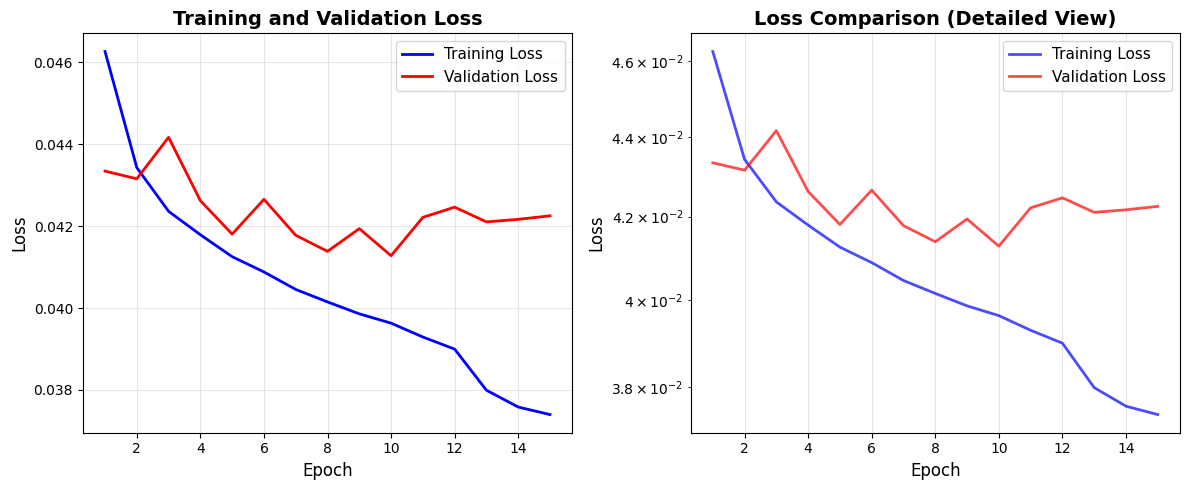


===== TRAINING SUMMARY =====
Final Training Loss: 0.0374
Final Validation Loss: 0.0423
Best Validation AUC: 0.8493
Total Epochs Trained: 15
Training stopped due to early stopping.


In [24]:
# ---------------- PLOT TRAINING CURVES ---------------- #
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_losses, 'b-', label='Training Loss', linewidth=2)
plt.plot(epochs_list, val_losses, 'r-', label='Validation Loss', linewidth=2)
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Plot validation AUC if available
if len(train_losses) > 0:
    plt.subplot(1, 2, 2)
    # We can't plot AUC here directly since we didn't store it, but we can show the loss comparison
    plt.plot(epochs_list, train_losses, 'b-', label='Training Loss', linewidth=2, alpha=0.7)
    plt.plot(epochs_list, val_losses, 'r-', label='Validation Loss', linewidth=2, alpha=0.7)
    plt.title('Loss Comparison (Detailed View)', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.yscale('log')  # Log scale for better visualization

plt.tight_layout()
plt.show()

# Print loss summary
print("\n===== TRAINING SUMMARY =====")
print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Final Validation Loss: {val_losses[-1]:.4f}")
print(f"Best Validation AUC: {best_val_auc:.4f}")
print(f"Total Epochs Trained: {len(train_losses)}")
if patience_counter >= CONFIG["patience"]:
    print("Training stopped due to early stopping.")

In [25]:
# ---------------- TEST ---------------- #
best_checkpoint_path = sorted([os.path.join(checkpoint_dir, f) for f in os.listdir(checkpoint_dir) if f.startswith('best_model_')])[-1]
model.load_state_dict(torch.load(best_checkpoint_path))
test_stats = evaluate(model, testloader, criterion, CONFIG["device"])

[Test]:   0%|          | 0/384 [00:00<?, ?it/s]

[Test] Atelectasis AUC: 0.8003 | F1: 0.3883
[Test] Cardiomegaly AUC: 0.9248 | F1: 0.4832
[Test] Consolidation AUC: 0.7691 | F1: 0.2361
[Test] Edema AUC: 0.8887 | F1: 0.2521
[Test] Effusion AUC: 0.9022 | F1: 0.6190
[Test] Emphysema AUC: 0.9612 | F1: 0.5298
[Test] Fibrosis AUC: 0.7895 | F1: 0.1562
[Test] Hernia AUC: 0.9804 | F1: 0.4615
[Test] Infiltration AUC: 0.7009 | F1: 0.3811
[Test] Mass AUC: 0.8773 | F1: 0.4554
[Test] Nodule AUC: 0.7602 | F1: 0.2977
[Test] Pleural_Thickening AUC: 0.7977 | F1: 0.2323
[Test] Pneumonia AUC: 0.7176 | F1: 0.0710
[Test] Pneumothorax AUC: 0.8781 | F1: 0.3698
[Test] Avg AUC: 0.8391, Avg F1: 0.3524


In [26]:
print("\n===== TEST RESULTS =====")

# Overall metrics
print(f"Loss      : {test_stats['loss']:.4f}")
print(f"Avg AUROC : {test_stats['avg_auc']:.4f}")
print(f"Avg F1    : {test_stats['avg_f1']:.4f}")

# Per-class metrics
print("\n=== Per-Class Metrics ===")
print("{:<20} {:<10} {:<10} {:<10}".format("Class", "AUROC", "F1", "Threshold"))
print("-" * 55)
for cls in test_stats['auc_dict'].keys():
    auc = test_stats['auc_dict'][cls]
    f1  = test_stats['f1_dict'][cls]
    thr = test_stats['thresholds'][cls]
    print("{:<20} {:<10.4f} {:<10.4f} {:<10.4f}".format(cls, auc, f1, thr))

# Optional: average threshold
avg_threshold = sum(test_stats['thresholds'].values()) / len(test_stats['thresholds'])
print("\nAverage Optimal Threshold across classes: {:.4f}".format(avg_threshold))



===== TEST RESULTS =====
Loss      : 0.0427
Avg AUROC : 0.8391
Avg F1    : 0.3524

=== Per-Class Metrics ===
Class                AUROC      F1         Threshold 
-------------------------------------------------------
Atelectasis          0.8003     0.3883     0.4012    
Cardiomegaly         0.9248     0.4832     0.3712    
Consolidation        0.7691     0.2361     0.3435    
Edema                0.8887     0.2521     0.3857    
Effusion             0.9022     0.6190     0.4732    
Emphysema            0.9612     0.5298     0.3146    
Fibrosis             0.7895     0.1562     0.3600    
Hernia               0.9804     0.4615     0.7729    
Infiltration         0.7009     0.3811     0.3603    
Mass                 0.8773     0.4554     0.4114    
Nodule               0.7602     0.2977     0.3308    
Pleural_Thickening   0.7977     0.2323     0.2930    
Pneumonia            0.7176     0.0710     0.2148    
Pneumothorax         0.8781     0.3698     0.3656    

Average Optimal Thresho

Generating predictions:   0%|          | 0/384 [00:00<?, ?it/s]

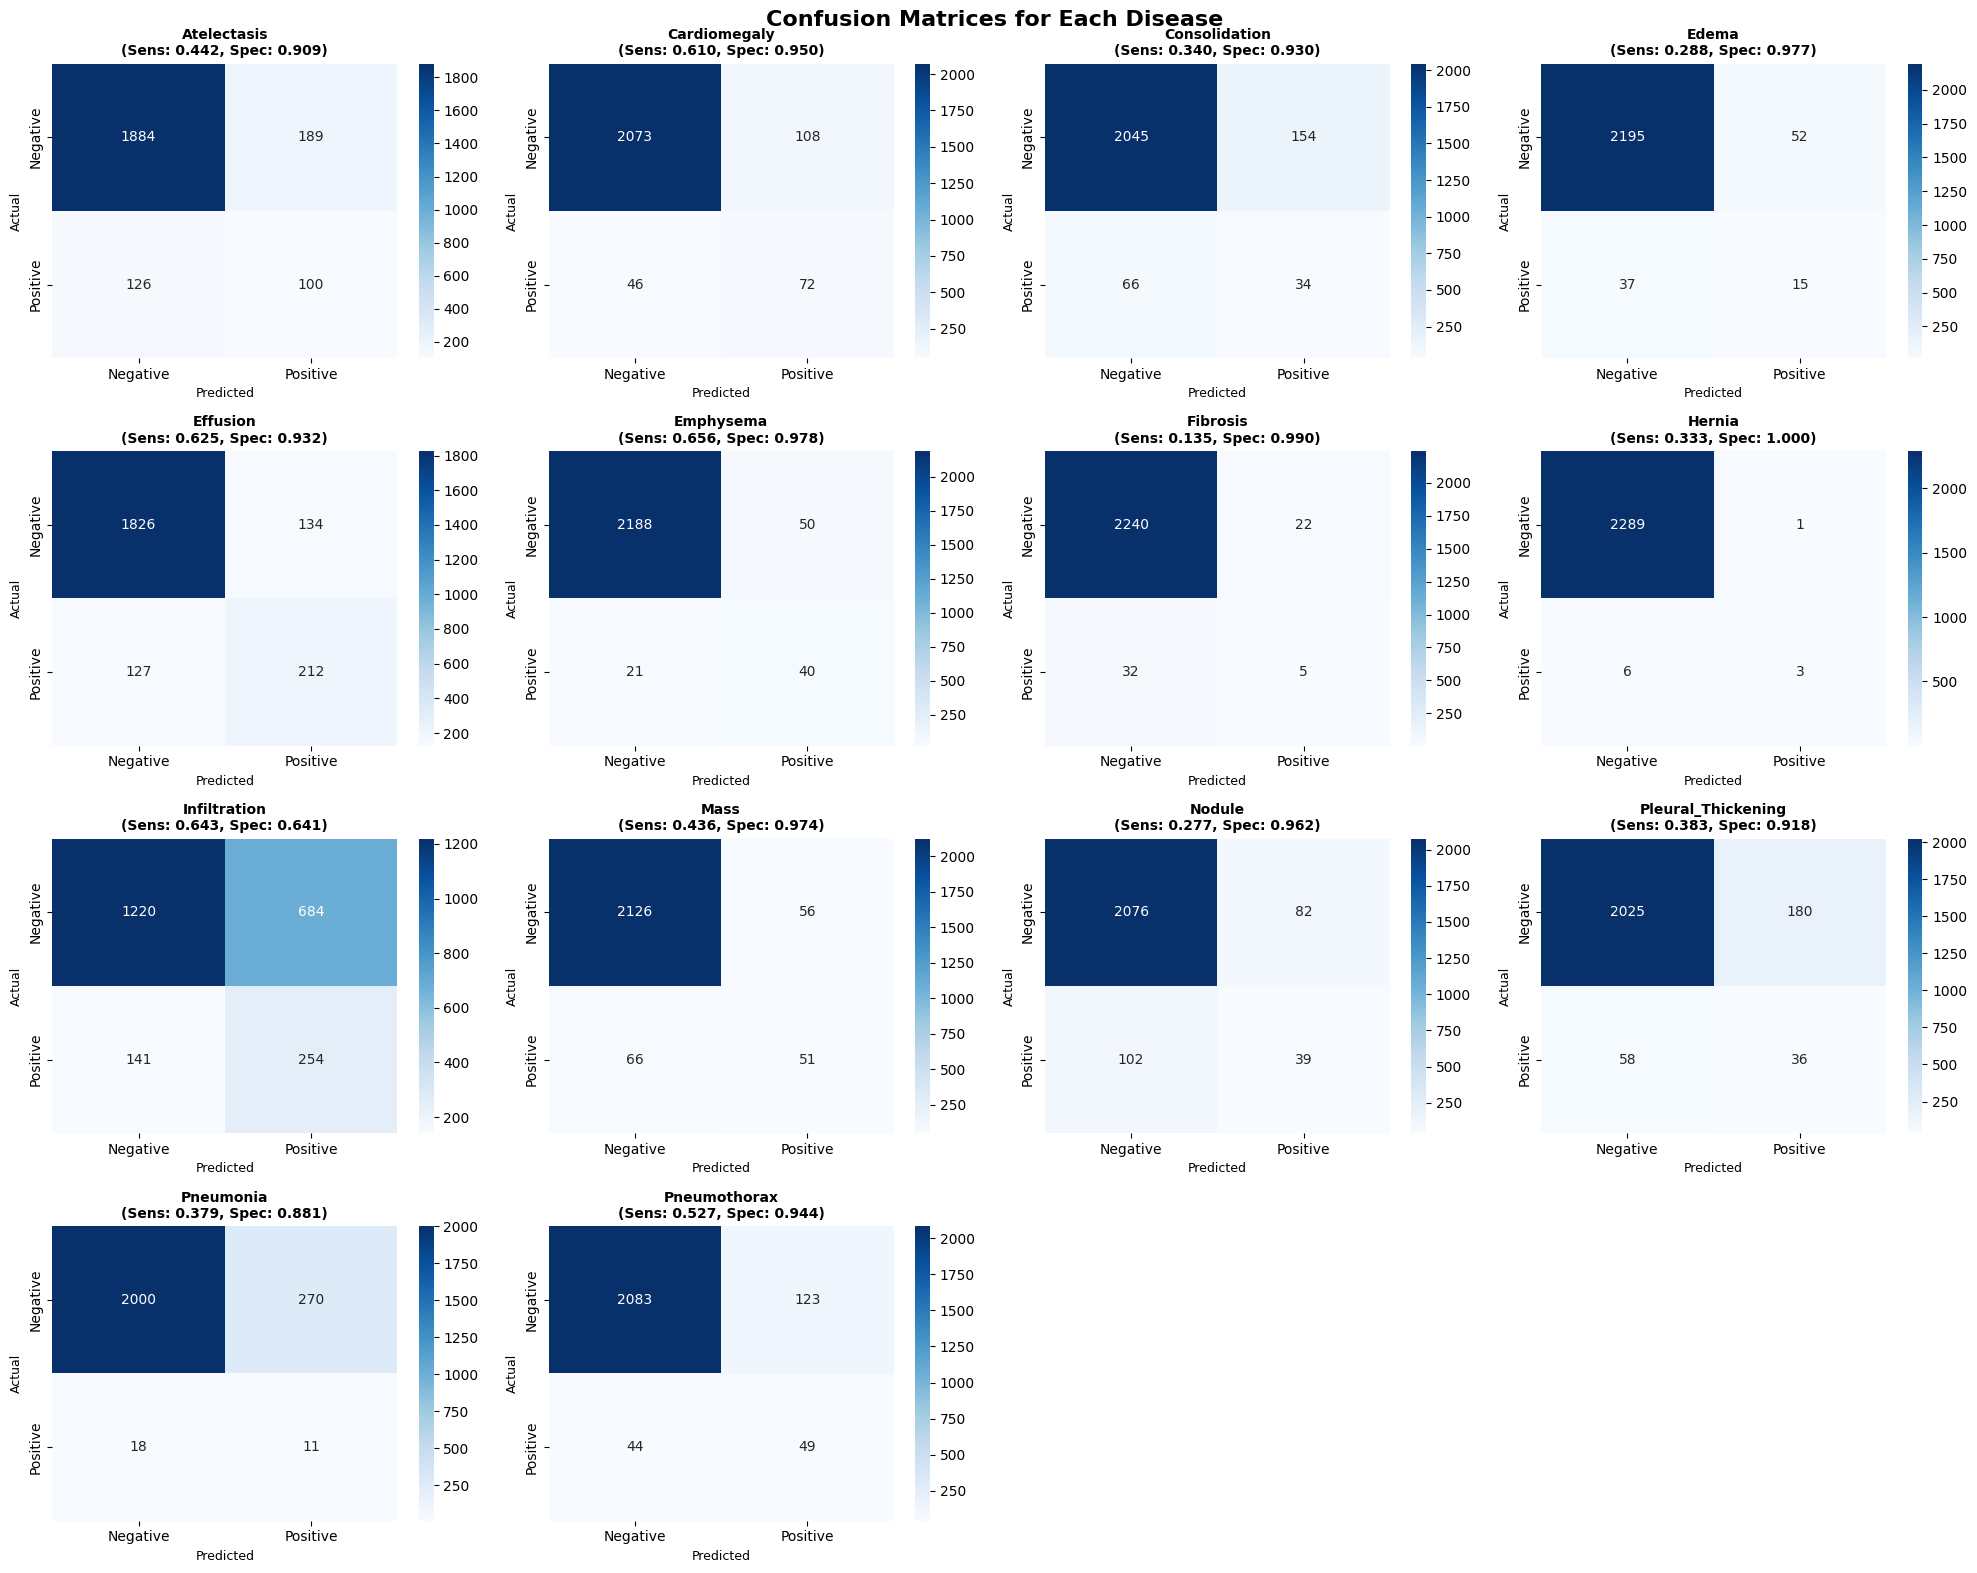

In [27]:
# ---------------- CONFUSION MATRIX ---------------- #
def generate_confusion_matrices(model, loader, device, thresholds):
    """
    Generate confusion matrices for multilabel classification.
    Since images can have multiple labels, we'll create individual confusion matrices for each disease.
    """
    model.eval()
    all_labels, all_preds = [], []
    
    print("Collecting predictions for confusion matrix...")
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Generating predictions"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.sigmoid(outputs)
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())

    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()
    
    # Convert predictions to binary using optimal thresholds
    preds_binary = np.zeros_like(all_preds)
    for i in range(all_preds.shape[1]):
        threshold = thresholds[disease_list[i]]
        preds_binary[:, i] = (all_preds[:, i] > threshold).astype(int)
    
    # Create confusion matrices for each disease
    n_diseases = len(disease_list)
    fig, axes = plt.subplots(4, 4, figsize=(20, 16))
    fig.suptitle('Confusion Matrices for Each Disease', fontsize=16, fontweight='bold')
    
    # Store confusion matrix metrics
    cm_metrics = {}
    
    for i, disease in enumerate(disease_list):
        row = i // 4
        col = i % 4
        ax = axes[row, col]
        
        # Generate confusion matrix for this disease
        cm = confusion_matrix(all_labels[:, i], preds_binary[:, i])
        
        # Calculate metrics
        tn, fp, fn, tp = cm.ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0
        
        cm_metrics[disease] = {
            'TP': int(tp), 'TN': int(tn), 'FP': int(fp), 'FN': int(fn),
            'Sensitivity': sensitivity, 'Specificity': specificity,
            'Precision': precision, 'NPV': npv
        }
        
        # Plot confusion matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                   xticklabels=['Negative', 'Positive'],
                   yticklabels=['Negative', 'Positive'])
        ax.set_title(f'{disease}\n(Sens: {sensitivity:.3f}, Spec: {specificity:.3f})', 
                    fontsize=10, fontweight='bold')
        ax.set_xlabel('Predicted', fontsize=9)
        ax.set_ylabel('Actual', fontsize=9)
    
    # Remove empty subplots (we have 14 diseases, so 2 empty spots)
    for i in range(n_diseases, 16):
        row = i // 4
        col = i % 4
        axes[row, col].remove()
    
    plt.tight_layout()
    plt.show()
    
    return cm_metrics

# Generate confusion matrices using test data and optimal thresholds
cm_metrics = generate_confusion_matrices(model, testloader, CONFIG["device"], test_stats['thresholds'])

In [28]:
# ---------------- DETAILED CONFUSION MATRIX METRICS ---------------- #
print("\n===== DETAILED CONFUSION MATRIX METRICS =====")
print("{:<20} {:<6} {:<6} {:<6} {:<6} {:<8} {:<8} {:<8} {:<8}".format(
    "Disease", "TP", "TN", "FP", "FN", "Sens", "Spec", "Prec", "NPV"))
print("-" * 100)

for disease, metrics in cm_metrics.items():
    print("{:<20} {:<6} {:<6} {:<6} {:<6} {:<8.3f} {:<8.3f} {:<8.3f} {:<8.3f}".format(
        disease, 
        metrics['TP'], metrics['TN'], metrics['FP'], metrics['FN'],
        metrics['Sensitivity'], metrics['Specificity'], 
        metrics['Precision'], metrics['NPV']
    ))

# Calculate and display average metrics
avg_sensitivity = np.mean([metrics['Sensitivity'] for metrics in cm_metrics.values()])
avg_specificity = np.mean([metrics['Specificity'] for metrics in cm_metrics.values()])
avg_precision = np.mean([metrics['Precision'] for metrics in cm_metrics.values()])
avg_npv = np.mean([metrics['NPV'] for metrics in cm_metrics.values()])

print("-" * 100)
print("{:<20} {:<6} {:<6} {:<6} {:<6} {:<8.3f} {:<8.3f} {:<8.3f} {:<8.3f}".format(
    "AVERAGE", "-", "-", "-", "-", avg_sensitivity, avg_specificity, avg_precision, avg_npv))

print(f"\n===== SUMMARY =====")
print(f"Average Sensitivity (Recall): {avg_sensitivity:.4f}")
print(f"Average Specificity: {avg_specificity:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average NPV: {avg_npv:.4f}")

# Additional multilabel-specific metrics
print(f"\n===== MULTILABEL CHARACTERISTICS =====")
total_samples = len(testloader.dataset)
# Count samples with multiple labels
samples_with_multiple_labels = 0
samples_with_no_findings = 0

# Count samples with multiple labels and no findings
for labels in testloader.dataset.dataframe['Finding Labels']:
    label_vector = get_label_vector(labels)
    if sum(label_vector) == 0:
        samples_with_no_findings += 1
    elif sum(label_vector) > 1:
        samples_with_multiple_labels += 1

print(f"Samples with multiple labels: {samples_with_multiple_labels}")
print(f"Samples with no findings: {samples_with_no_findings}")
print(f"Total test samples: {total_samples}")
print("Note: This is a multilabel classification problem where each image can have multiple diseases simultaneously.")


===== DETAILED CONFUSION MATRIX METRICS =====
Disease              TP     TN     FP     FN     Sens     Spec     Prec     NPV     
----------------------------------------------------------------------------------------------------
Atelectasis          100    1884   189    126    0.442    0.909    0.346    0.937   
Cardiomegaly         72     2073   108    46     0.610    0.950    0.400    0.978   
Consolidation        34     2045   154    66     0.340    0.930    0.181    0.969   
Edema                15     2195   52     37     0.288    0.977    0.224    0.983   
Effusion             212    1826   134    127    0.625    0.932    0.613    0.935   
Emphysema            40     2188   50     21     0.656    0.978    0.444    0.990   
Fibrosis             5      2240   22     32     0.135    0.990    0.185    0.986   
Hernia               3      2289   1      6      0.333    1.000    0.750    0.997   
Infiltration         254    1220   684    141    0.643    0.641    0.271    0.896   
Ma